# Import libraries

In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

In [2]:
from scripts.parse_vars import parse_variables

In [3]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])

commands = [
    f"G <- {G}",
    f"L <- {L}",
    f"c <- {c}",
    f"k <- {k}",
    f"M <- {M}",
    f'setwd("{R_directory}")',
    f'source("{R_file}", echo=TRUE)'
]


# Concatenate commands into a single string
r_script = ";".join(commands)

# Run the R script
result = subprocess.run(['Rscript', '-e', r_script], capture_output=True, text=True)


In [5]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
humans = pd.read_pickle(f"{path_pheno}/humans.pkl")

In [6]:
humans['z'] = int(F)

In [7]:
# Define a function to map values to colors
def map_to_color(x, y, z, df):
    # Check if there's variance to avoid division by zero
    r = x / df['x'].max() if df['x'].max() != 0 else 0  # Red component based on 'x'
    g = y / df['y'].max() if df['y'].max() != 0 else 0  # Green component based on 'y'
    b = z / df['z'].max() if df['z'].max() != 0 else 0  # Blue component based on 'z'
    
    return (r, g, b)

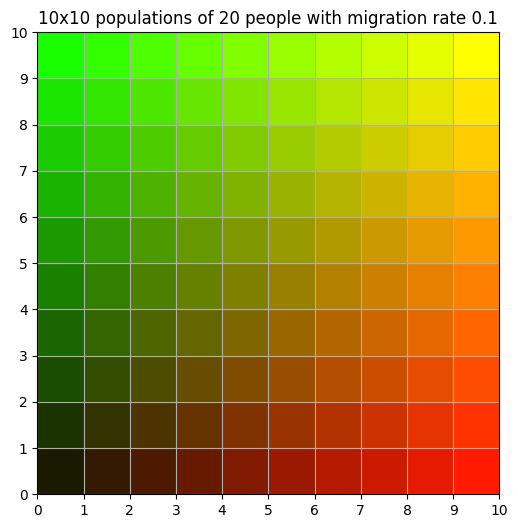

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # Get the first matching row for x=i+1 and y=j+1
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        color = map_to_color(row['x'], row['y'], row['populations'], humans)
        ax.add_patch(plt.Rectangle((i, j), 1, 1, color=color))

# Formatting the plot
ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()

# creating environmental effects

In [9]:
pheno = humans[['x','y']].copy()
pheno['01_pheno_linear'] = pheno['x'] + pheno['y']
# Sinusoidal pattern (e.g., across x)
freq_x = 3  # 3 full sine cycles across the x-dimension
freq_y = 2  # 2 full sine cycles across the y-dimension

pheno['02_pheno_sine_x'] = np.round(np.sin(pheno['x'] * freq_x * np.pi / k), 2)
pheno['03_pheno_sine_y'] = np.round(np.sin(pheno['y'] * freq_y * np.pi / k), 2)
# Interaction term (e.g., product of x and y)
pheno['04_pheno_sine_x_y'] = np.round(pheno['02_pheno_sine_x'] + pheno['03_pheno_sine_y'],2)
n = int(k - k//3)
pheno['05_pheno_discrete'] = ((pheno['x'] == n) & (pheno['y'] == n)).astype(int)

from sklearn.preprocessing import MinMaxScaler

# Define a function to scale to [-1, 1]
def scale_minus1_to_1(series):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

# Apply scaling to all relevant phenotypes
for col in ['01_pheno_linear', '02_pheno_sine_x', '03_pheno_sine_y', '04_pheno_sine_x_y']:
    pheno[col] = scale_minus1_to_1(pheno[col])


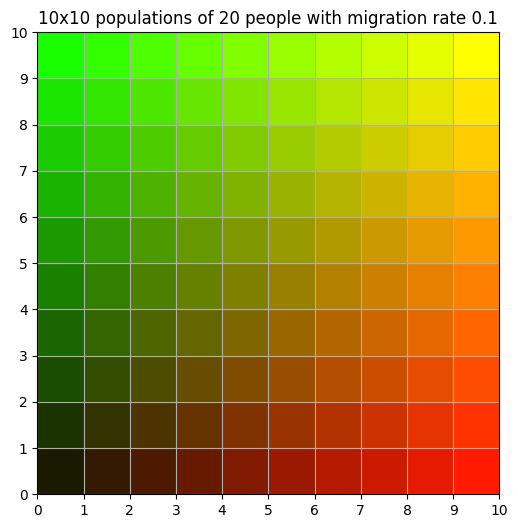

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # Get the first matching row for x=i+1 and y=j+1
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        color = map_to_color(row['x'], row['y'], row['populations'], humans)
        ax.add_patch(plt.Rectangle((i, j), 1, 1, color=color))

# Formatting the plot
ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()

## linear

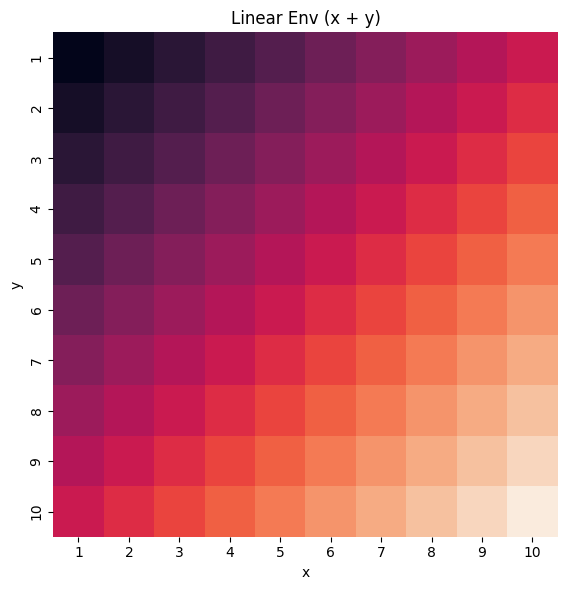

In [11]:
# Aggregate to ensure one value per (x, y)
pheno_agg = pheno.groupby(['y', 'x'])['01_pheno_linear'].mean().reset_index()

# Pivot to wide format
pivoted = pheno_agg.pivot(index='y', columns='x', values='01_pheno_linear')

plt.figure(figsize=(6, 6))
sns.heatmap(
    pivoted,
    cmap='rocket',
    square=True,
    cbar=False  # <- disables the colorbar
)
plt.title("Linear Env (x + y)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

## Non-linear

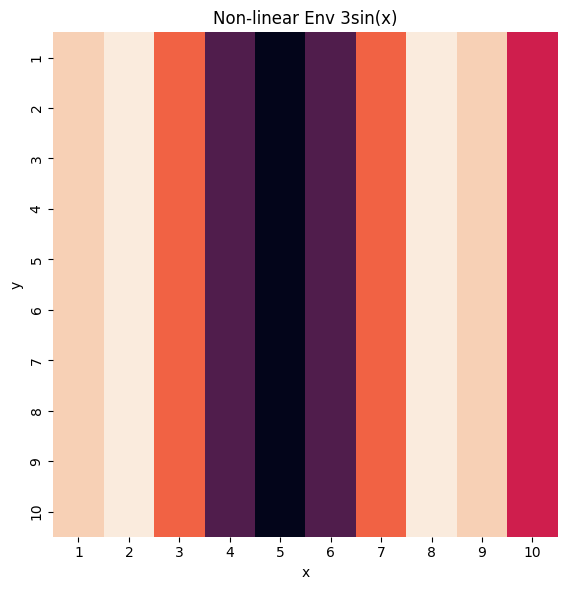

In [12]:
# Aggregate to ensure one value per (x, y)
pheno_agg = pheno.groupby(['y', 'x'])['02_pheno_sine_x'].mean().reset_index()

# Pivot to wide format
pivoted = pheno_agg.pivot(index='y', columns='x', values='02_pheno_sine_x')

plt.figure(figsize=(6, 6))
sns.heatmap(
    pivoted,
    cmap='rocket',
    square=True,
    cbar=False  # <- disables the colorbar
)
plt.title(f"Non-linear Env {freq_x}sin(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

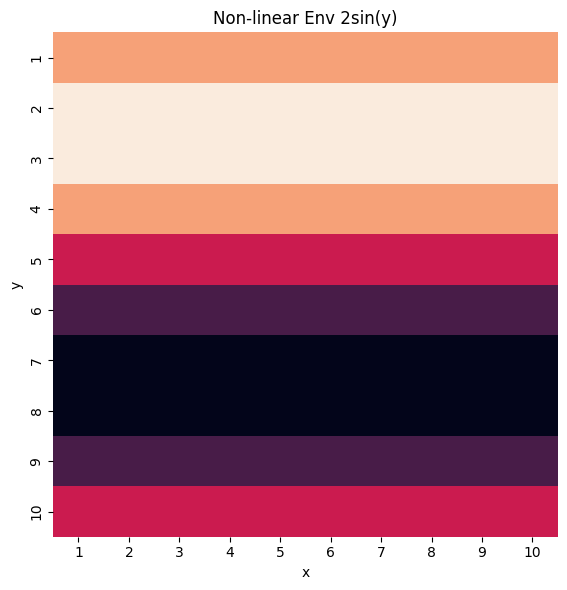

In [13]:
# Aggregate to ensure one value per (x, y)
pheno_agg = pheno.groupby(['y', 'x'])['03_pheno_sine_y'].mean().reset_index()

# Pivot to wide format
pivoted = pheno_agg.pivot(index='y', columns='x', values='03_pheno_sine_y')

plt.figure(figsize=(6, 6))
sns.heatmap(
    pivoted,
    cmap='rocket',
    square=True,
    cbar=False  # <- disables the colorbar
)
plt.title(f"Non-linear Env {freq_y}sin(y)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

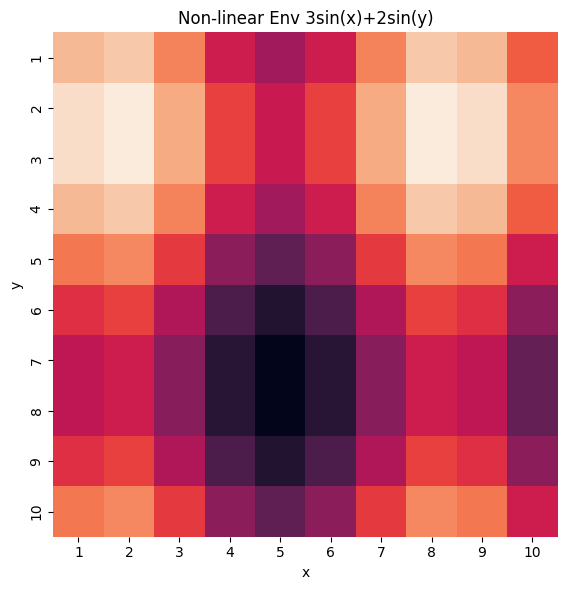

In [14]:
# Aggregate to ensure one value per (x, y)
pheno_agg = pheno.groupby(['y', 'x'])['04_pheno_sine_x_y'].mean().reset_index()

# Pivot to wide format
pivoted = pheno_agg.pivot(index='y', columns='x', values='04_pheno_sine_x_y')

plt.figure(figsize=(6, 6))
sns.heatmap(
    pivoted,
    cmap='rocket',
    square=True,
    cbar=False  # <- disables the colorbar
)
plt.title(f"Non-linear Env {freq_x}sin(x)+{freq_y}sin(y)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

## Discrete

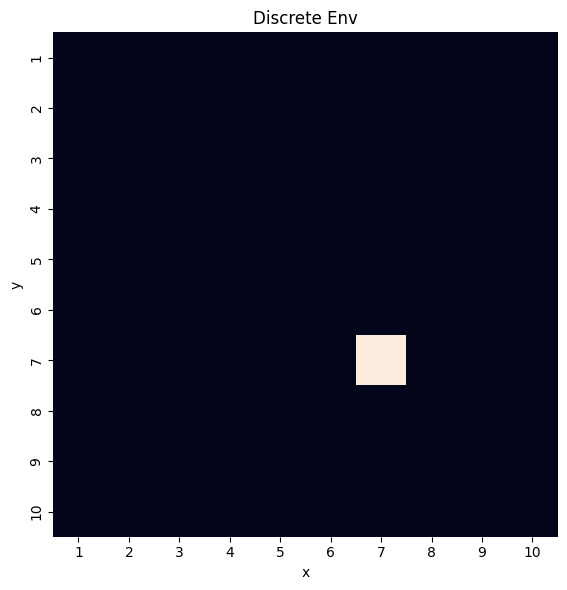

In [15]:
# Aggregate to ensure one value per (x, y)
pheno_agg = pheno.groupby(['y', 'x'])['05_pheno_discrete'].mean().reset_index()

# Pivot to wide format
pivoted = pheno_agg.pivot(index='y', columns='x', values='05_pheno_discrete')

plt.figure(figsize=(6, 6))
sns.heatmap(
    pivoted,
    cmap='rocket',
    square=True,
    cbar=False  # <- disables the colorbar
)
plt.title(f"Discrete Env")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

In [16]:
pheno

,x,y,01_pheno_linear,02_pheno_sine_x,03_pheno_sine_y,04_pheno_sine_x_y,05_pheno_discrete
0,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
1,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
2,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
3,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
4,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
...,...,...,...,...,...,...,...
1995,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1996,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1997,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1998,10,10,1.0,0.025641,-1.110223e-16,0.012987,0


In [17]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
pheno.to_pickle(f"{path_pheno}/env_pheno.pkl")